# 2D integration: Part II

Now that we have established how to numerically construct the matrix governing the advection-diffusion dynamics, we can now actually show the simulation of a 2D system. To start, we will look at open boundary conditions, starting in a Gaussian disstribution in 2 dimensions, and we will then see the system diffuse out of the domain in both the X and Y dimensions.

Next we will investigate the behaviour of a system wiht hard-wall boundary conditions in a harmonic potential:

$$ E(x, y) = \frac{k}{2}(x^2 + y^2) $$

Below is a plot of this potential. Essentially, we just want to see the equilibration of this system. We will initialize the system in a uniform distribution, and observe how the system relaxes towards it equilibrium distribution in both the X and Y dimensions.

Finally, we will also look at the behaviour of a periodic system, governed by the potential

In [40]:
# First, import the necessary components
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

sns.set(style='darkgrid', palette='hls')

from FPE.integrator_2D import FPE_integrator_2D

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# To start lets plot the energy potentials, both as surface plots and as density plots
# using seaborn

# fist define X and Y coordinates
x_array = np.arange(-1.0, 1.0, 0.01)
k_trap = 1.0

X, Y = np.meshgrid(x_array, x_array)
Z_harmonic = k_trap * 0.5 * (X**2 + Y**2)
Z_periodic = np.cos(2 * np.pi * X) + np.cos(2 * np.pi * Y)


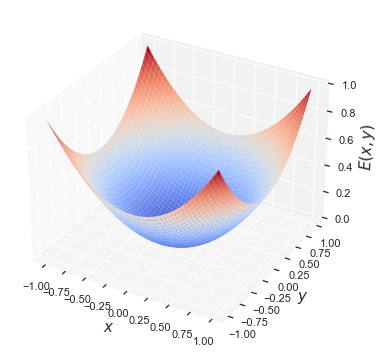

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), subplot_kw={"projection": "3d"})

ax.plot_surface(X, Y, Z_harmonic, cmap=cm.coolwarm, linewidth=0)
ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"$y$", fontsize=15)
ax.set_zlabel(r"$E(x, y)$", fontsize=15)

ax.set_facecolor('white')
plt.tight_layout()
plt.show()


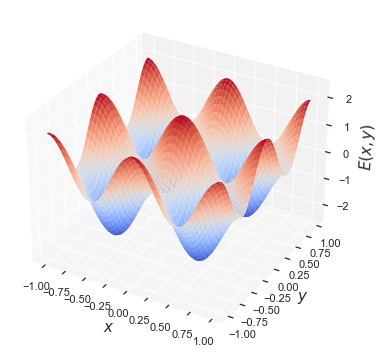

In [35]:
# And then for the sinusoidal plot

fig, ax = plt.subplots(1, 1, figsize=(6, 5), subplot_kw={"projection": "3d"})

ax.plot_surface(X, Y, Z_periodic, cmap=cm.coolwarm, linewidth=0)
ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"$y$", fontsize=15)
ax.set_zlabel(r"$E(x, y)$", fontsize=15)
ax.set_zlim([-2.5, 2.5])

ax.set_facecolor('white')
plt.tight_layout()
plt.show()

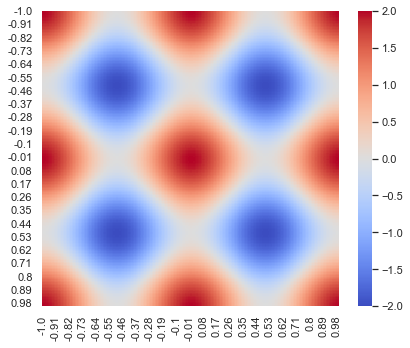

In [75]:
# and then as heatmaps
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

df_periodic = pd.DataFrame(Z_periodic, index=np.round(x_array, 2), columns=np.round(x_array, 2))
sns.heatmap(df_periodic, cmap='coolwarm')
plt.tight_layout()
plt.show()


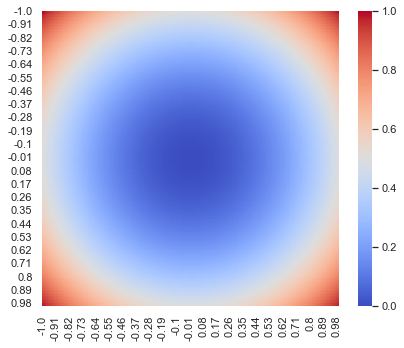

In [76]:
# and then as heatmaps
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

df_harmonic = pd.DataFrame(Z_harmonic, index=np.round(x_array, 2), columns=np.round(x_array, 2))
sns.heatmap(df_harmonic, cmap='coolwarm')
plt.tight_layout()
plt.show()


In [131]:
# So, now we can actually initialize a few sample systems.  To start, we will
# initialize a system in a Gaussian distribution (with no correlation), open
# boundaries, and observe the subsequent diffusion out of the domain

D = 1.0
dt = 0.01
dx = 0.02
dy = 0.02
x_array = np.arange(-1, 1, dx)
y_array = np.arange(-1, 1, dy)

fpe_2d_open = FPE_integrator_2D(D, dt, dx, dx, x_array, y_array, boundaryCond='open')

In [162]:
# Now to  initialize the probability
var_x = 1. / 16
var_y = 1. / 24
norm_factor = (1 / (2 * np.pi * np.sqrt(var_x * var_y)))

X, Y = np.meshgrid(x_array, y_array)
Z = norm_factor * np.exp(-0.5 * ((X**2 / var_x) + (Y**2 / var_y)))

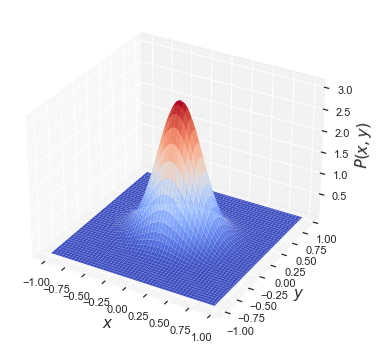

In [163]:
# which we can plot to be sure that things look correct
fig, ax = plt.subplots(1, 1, figsize=(6, 5), subplot_kw={"projection": "3d"})

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0)
ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"$y$", fontsize=15)
ax.set_zlabel(r"$P(x, y)$", fontsize=15)

ax.set_facecolor('white')
plt.tight_layout()
plt.show()

In [164]:
# And we can chack the normalization as well, this looks suspiciously
# inaccurate for some reason, I'll look into this

np.sum(Z) * dx * dy

0.9999351048549382

In [165]:
# Now, we want to broadcast this into a 1D vector, that preserves matrix rows
# i.e. we have prob = [row1, row2, row3, ...]

prob_init = Z.flatten(order='C')

In [166]:
prob_init.shape

(10000,)

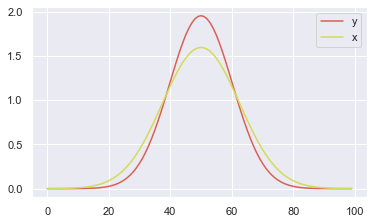

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

temp_2d = prob_init.reshape(Ny, Nx)

ax.plot(temp_2d.sum(axis=1) * dy, label='y')
ax.plot(temp_2d.sum(axis=0) * dx, label="x")
ax.legend()

In [137]:
# Finally, we can use this to initialize the probability vector in the integrator

fpe_2d_open.prob = prob_init


In [138]:
# And then we can integrate the dynamics
time_tracker = [0]
prob_tracker = [prob_init]
force_params = ()
force_function = (lambda x: 0)
for t in range(100):
    fpe_2d_open.integrate_step(force_params, force_function, force_function)
    if t % 10 == 0:
        time_tracker.append(t * dt)
        prob_tracker.append(fpe_2d_open.prob.copy())


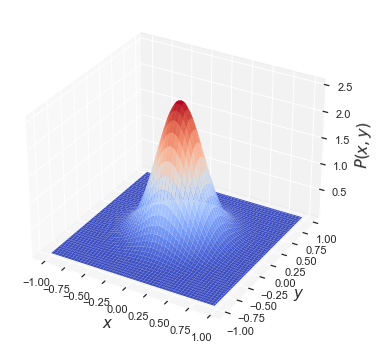

In [142]:
# Now, we also need a way to convert the flattened array back into a matrix
# this can be done with vanilla numpy through the reshape operator

fig, ax = plt.subplots(1, 1, figsize=(6, 5), subplot_kw={"projection": "3d"})

prob_2d = prob_init.reshape(fpe_2d_open.Nx, fpe_2d_open.Ny)
ax.plot_surface(X, Y, prob_2d, cmap=cm.coolwarm, linewidth=0)
ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"$y$", fontsize=15)
ax.set_zlabel(r"$P(x, y)$", fontsize=15)

ax.set_facecolor('white')
plt.tight_layout()
plt.show()

In [143]:
# And now we can so the same things over time

Nx = fpe_2d_open.Nx
Ny = fpe_2d_open.Ny

prob_tracker_2d = [prob.reshape(Nx, Ny) for prob in prob_tracker]

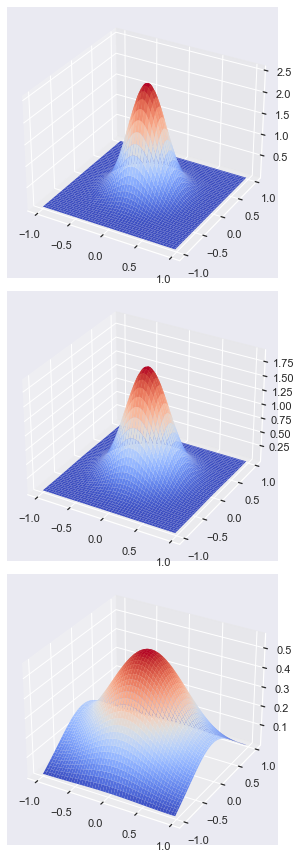

In [149]:
# and then plot them all

fig, ax = plt.subplots(3, 1, figsize=(6, 12), subplot_kw={"projection": "3d"})

ax[0].plot_surface(X, Y, prob_tracker_2d[0], cmap=cm.coolwarm, linewidth=0)
ax[1].plot_surface(X, Y, prob_tracker_2d[1], cmap=cm.coolwarm, linewidth=0)
ax[2].plot_surface(X, Y, prob_tracker_2d[2], cmap=cm.coolwarm, linewidth=0)

# ax.set_xlabel(r"$x$", fontsize=15)
# ax.set_ylabel(r"$y$", fontsize=15)
# ax.set_zlabel(r"$P(x, y)$", fontsize=15)

# ax.set_facecolor('white')
plt.tight_layout()
plt.show()

<AxesSubplot:>

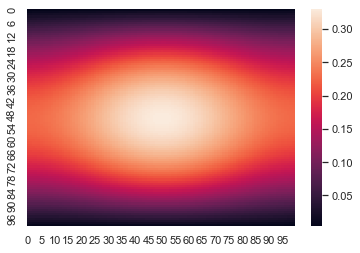

In [151]:
# So it looks like its not diffusing in the y direction...
sns.heatmap(prob_tracker_2d[3])

<AxesSubplot:>

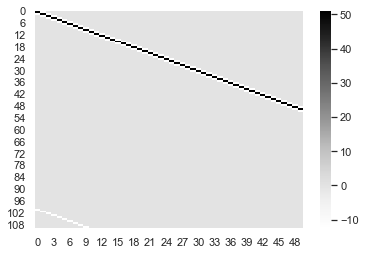

In [158]:
sns.heatmap(fpe_2d_open.AMat.toarray()[:110, :50], cmap="Greys")

In [157]:
fpe_2d_open.Nx

100

In [159]:
prob_y_tracker = [prob.sum(axis=1) * dx for prob in prob_tracker_2d]
prob_x_tracker = [prob.sum(axis=0) * dy for prob in prob_tracker_2d]

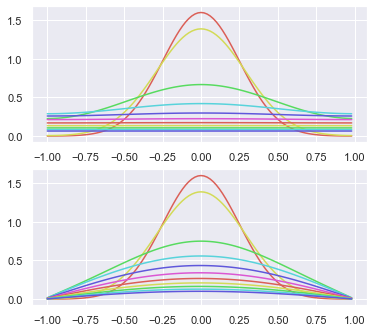

In [161]:
fig, ax = plt.subplots(2, 1, figsize=(6, 5.5))
# Weird... Its working in Y but not X...

for py, px in zip(prob_y_tracker, prob_x_tracker):
    ax[0].plot(x_array, px)
    ax[1].plot(x_array, py)
    
